# Projet ELTDM : Optimisation de l'inférence d'un classifieur RandomForest  en utilisant une représentation matricielle


## Introduction
En Machine Learning, les tâches d'apprentissage et d'inférence, pourtant très liées, répondent à des cahiers des charges très différents.

La tâche d'apprentissage requiert de pouvoir ingérer de larges volumes de données, d'être paramétrable, de posséder des représentations internes lisibles, interprétables et facilement déboguables, et surtout de tout mettre en oeuvre pour arriver à la meilleure performance prédictive possible. Si le temps d'exécution peut être important pour assurer un haut débit de données ingérées, la latence d'une prédiction est rarement une considération importante pour la phase d'apprentissage.

La tâche d'inférence, elle, a souvent pour priorités non seulement le débit, mais aussi la latence des prédictions et les empreintes mémoire et disque. L'interprétabilité des représentations internes est moins importante car la phase d'expérimentation est finie.

La bibliothèque python `scikit-learn` propose des implémentations de nombreux algorithmes courants de Machine Learning, auxquelles on peut accéder par une API très simple (un modèle = un objet ayant une méthode `.fit` et une méthode `.predict`) et dont le code est souvent plutôt simple et direct. Un exemple d'algorithme très populaire implémenté dans ce package est l'algorithme Random Forest. Nous nous proposons d'utiliser l'implémentation proposée par `scikit-learn` pour l'apprentissage, mais de transformer l'algorithme sous une forme matricielle une fois l'apprentissage achevé pour accélérer l'inférence.

Nous commencerons par expliquer le fonctionnement de l'algorithme RandomForest, puis d'en expliquer la version matricielle.

Nous proposerons une première implémentation naïve de la version matricielle de l'algorithme et mesurerons sa vitesse sur CPU (avec `numpy` et `pytorch`) et GPU (avec `pytorch`).

Nous proposerons enfin une implémentation plus optimisée, dont la vitesse est proche de celle de l'implémentation proposée par la bibliothèque `hummingbird`, ce qui a constitué notre objectif pour ce projet.

Notre implémentation finale sur carte graphique parvient à diviser par 30 le temps d'inférence sur l'exemple de modèle choisi.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification, make_circles, make_moons
from hummingbird.ml import convert
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import graphviz

from random_forest_pytorch.utils import plot_decision_tree, get_all_backends, pretty_print_time_all_backends, time_all_backends, make_complex_dataset
from random_forest_pytorch.random_forest_gemm import RandomForestGEMM, DecisionTreeGEMM, NaiveRandomForestGEMM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Explication de l'algorithme Random Forest
### Objectif de l'algorithme
Nous présenterons ici l'algorithme dans le cadre du problème de classification binaire, mais les principes exposés se généralisent facilement aux autres cadres. 

L'algorithme RandomForest est un modèle classique de Machine Learning, basé sur le principe d'*ensembling*. L'idée est qu'un grand nombre de prédicteurs faibles, si leurs prédictions sont suffisamment complémentaires, peuvent devenir un classifieur puissant lorsque leurs prédictions sont aggrégées. Dans le cas de RandomForest, le classifieur faible utilisé est un arbre de décision, souvent peu profond.

### L'arbre de décision

Un arbre de décision est un modèle simple d'apprentissage supervisé qui vise à approximer une fonction cible par une succession de décisions binaires portant chacune sur une seule *feature*.

Le plus simple est d'illustrer cet algorithme par un exemple graphique sur un jeu de données très simple.

In [2]:
X, y = make_circles(n_samples=100, factor=0.6)
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=4)

D'abord, visualisons le jeu de données et les prédictions faites par l'arbre sur celui-ci.

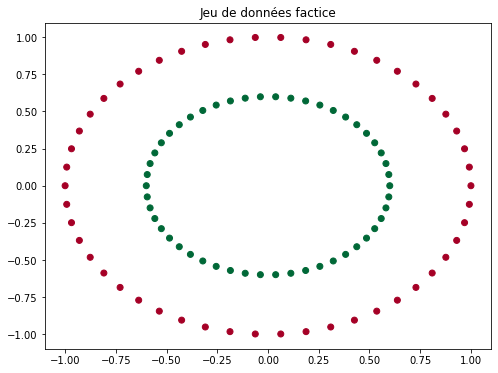

In [3]:
plt.subplots(figsize=(8, 6))
plt.title("Jeu de données factice")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="RdYlGn");

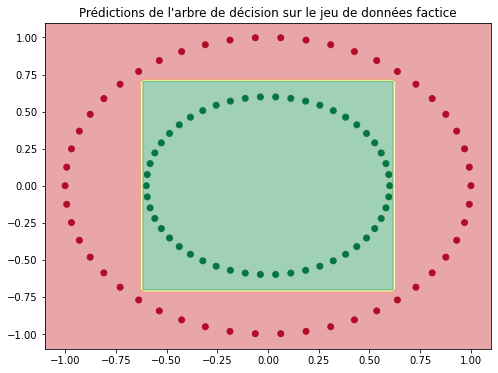

In [4]:
plt.subplots(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="RdYlGn")

grid_1d = np.linspace(-1.1, 1.1, 100)
xx, yy = np.meshgrid(grid_1d, grid_1d)
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn")

plt.title("Prédictions de l'arbre de décision sur le jeu de données factice");

L'arbre prédit parfaitement la classe, mais sa frontière de décision est un rectangle. En effet, l'arbre ne prend que des décisions binaires sur une seule *feature* à la fois, ce qui explique la forme du graphe ci-dessus.

Visualisons son processus de prédiction :

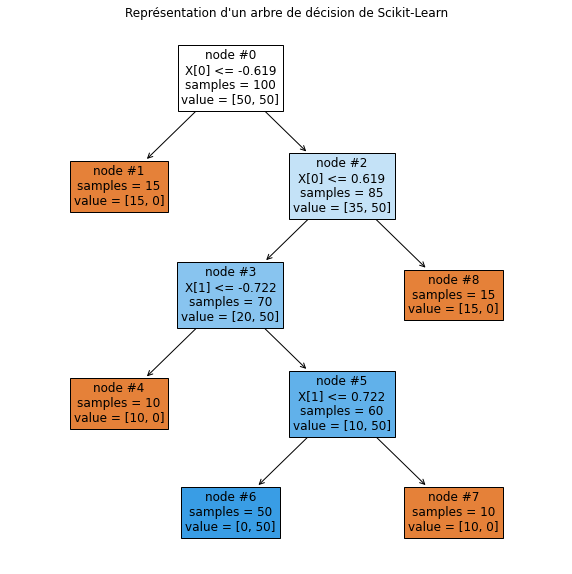

In [5]:
plot_decision_tree(tree)
plt.title("Représentation d'un arbre de décision de Scikit-Learn");

Comme on peut le voir, l'arbre opère une disjonction de cas sur 5 cas possibles, avec un seul cas (l'intérieur du rectangle) étant de la classe représentée en vert sur le graphique et les quatre autres étant la classe rouge.

### RandomForest : un ensemble d'arbres de décision
En utilisant conjointement de nombreux arbres de décision, entraînés sur des sous-ensembles des données, on peut souvent arriver à de bien meilleures classifications. Ces modèles sont rapides à entraîner, interprétables, et très efficaces sans beaucoup de manipulation d'hyperparamètres, ce qui a fait leur popularité.

L'exemple ci-dessous montre la capacité de ces modèles à apprendre des frontières de décision complexes.

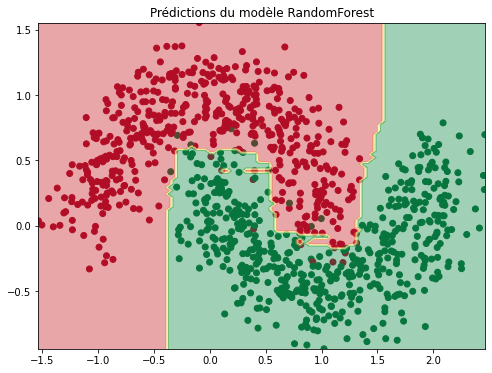

In [6]:
X, y = make_moons(n_samples=1000, noise=0.2)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)

plt.subplots(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="RdYlGn")

grid_1d = np.linspace(-1.1, 1.1, 100)
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
Z = rf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn")

plt.title("Prédictions du modèle RandomForest");

Ici, nous allons entraîner un classifieur RandomForest sur un jeu de données synthétique, et l'utiliser comme exemple pour illustrer nos optimisations.

In [7]:
X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=True)
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

## La version matricielle de RandomForest

### Présentation de l'algorithme GEMM sur un arbre de décision

Le terme GEMM (GEneric Matrix Multiplication) désigne l'opération de multiplication matricielle, dont les implémentations notamment sur GPU sont très optimisées. L'algorithme DecisionTree GEMM, que nous appellerons par la suite simplement GEMM, vise à procéder à l'inférence d'un arbre de décision uniquement sous la forme de multiplications de matrices.

Le but de l'algorithme est donc de vectoriser les tests effectués par les noeuds de l'arbre. Pour expliquer cet algorithme, prenons pour exemple le premier arbre de la RandomForest que nous venons d'entraîner :

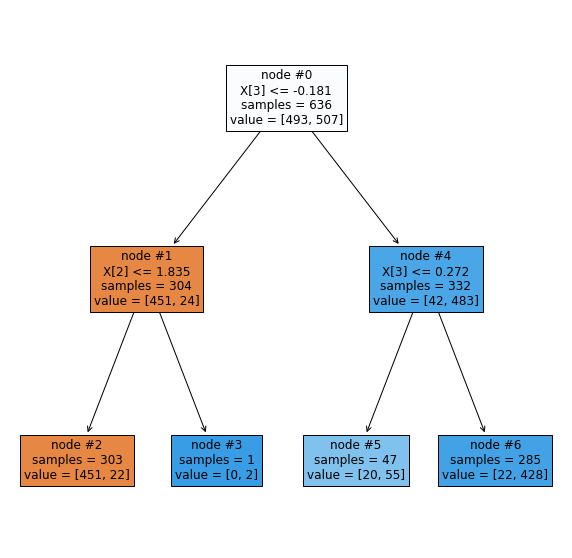

In [8]:
tree = clf.estimators_[0]
plot_decision_tree(tree)

Il s'agit d'un arbre de classification binaire constitué de 3 noeuds internes (les noeuds 0, 1, et 4) et de 4 feuilles (les noeuds 2, 3, 5 et 6). Nous allons invoquer notre fonction de conversion et expliquer ses composantes.

In [9]:
gemm_tree = DecisionTreeGEMM(tree)

In [10]:
for mat in "ABCDE":
    print(f"Matrice {mat} :")
    print(gemm_tree.__getattribute__(mat))
    print("")

Matrice A :
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 1.]]

Matrice B :
[-0.18058992  1.83501905  0.27233107]

Matrice C :
[[ 1.  1. -1. -1.]
 [ 1. -1.  0.  0.]
 [ 0.  0.  1. -1.]]

Matrice D :
[2 1 1 0]

Matrice E :
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]



Ici, l'arbre effectue un total de 3 tests.

L'entrée de l'arbre est un vecteur de features $x$, ici de taille 4.

Voici comment l'algorithme vectorise les tests de comparaison :

1. D'abord, une première matrice $A$ détermine sur quelles features les 3 tests vont porter. Chaque colonne représente un test et chaque ligne représente une feature. Ici, les tests portent dans l'ordre sur les features d'index 3, 2 et 3. Les features d'index 0 et 1 ne sont pas utilisées par l'arbre lors de l'inférence, ce qui explique les deux lignes à 0. On définit $x_1 = xA$ pour obtenir un vecteur de taille 3.
2. La matrice $B$ contient les seuils des trois tests. On compare $x_1$ terme à terme avec $B$ pour obtenir un nouveau vecteur $x_2$ contenant des 0 et des 1 représentant les résultats des tests.
3. La matrice $C$ permet de trouver le chemin parcouru par le sample dans l'arbre. Chaque ligne indique vers quels sous-noeuds un noeud donné pointe en fonction du résultat de son test. On calcule $x_3 = x_2 C$, qui est un vecteur avec autant de coordonnées que de feuilles de l'arbre. Chaque coefficient de ce vecteur indique combien des tests menant à cette feuille ont été réussis par le sample, moins le nombre de ces tests qui ont été échoués.
4. Ensuite, on compare terme à terme $x_4$ avec la matrice $D$, qui indique pour chaque feuille le nombre de réussites moins le nombre d'échecs qu'il faut pour l'atteindre. On peut vérifier qu'une seule de ces égalités sera vraie, ce qui donne un vecteur avec un 1 à la feuille dans laquelle atterrit le sample, et des 0 ailleurs.
5. Enfin, on multiplie $x_4$ par la matrice $E$, qui indique la classe majoritaire dans les 4 feuilles, et on obtient un vecteur à deux composantes, dont l'une vaut 1 et indique la classe majoritaire de cette feuille (la prédiction de l'arbre), et l'autre vaut 0.

La cellule ci-dessous montre la succession de calculs pour un exemple qui atterrit dans la feuille de gauche.

In [11]:
x = np.array([0, 0, 0, -1])

x_1 = x@gemm_tree.A
x_2 = (x_1 < gemm_tree.B).astype("float")
x_3 = x_2 @ gemm_tree.C
x_4 = (x_3 == gemm_tree.D).astype("float")
x_5 = x_4 @ gemm_tree.E
x_5

array([1., 0.])

In [12]:
# La feuille atteinte est bien celle de gauche
x_4

array([1., 0., 0., 0.])

Ce calcul a été mené sur un seul sample. Il est possible d'empiler les vecteurs de sample dans une matrice X et d'utiliser les mêmes étapes de calculs illustrées ci-dessus.

### Implémentation Naïve
Une fois cette représentation définie, on peut implémenter une RandomForest naïve en définissant une liste d'arbres de décisions mis sous forme matricielles, calculer leurs prédictions indépendamment, puis les aggréger pour produire une prédiction finale. Mesurons l'impact de ce choix sur la performance de l'algorithme.

Nous avons implémenté cet algorithme sous trois backends : ``numpy``, ``pytorch`` sur CPU, et ``pytorch`` sur GPU. Nous allons mesurer la vitesse des trois.

In [13]:
naive_models = get_all_backends(NaiveRandomForestGEMM, clf)
naive_models

{'sklearn': RandomForestClassifier(max_depth=2, random_state=0),
 'numpy': <random_forest_pytorch.random_forest_gemm.NaiveRandomForestGEMM at 0x7f8798d0cb50>,
 'torch_cpu': <random_forest_pytorch.random_forest_gemm.NaiveRandomForestGEMM at 0x7f8798d0c5b0>,
 'torch_cuda': <random_forest_pytorch.random_forest_gemm.NaiveRandomForestGEMM at 0x7f8798d0ccd0>}

In [14]:
pretty_print_time_all_backends(naive_models, X, number=100, repeat=7)

sklearn           -> 13.6 ms ±  386 µs
numpy             -> 5.43 ms ±  216 µs
torch_cpu         -> 8.48 ms ±  269 µs
torch_cuda        -> 11.4 ms ±  343 µs


Malgré cette implémentation naïve, nous arrivons en utilisant `numpy` à diviser par 2.5 le temps d'exécution, ce qui est déjà considérable.

### Implémentation optimisée
Cependant, le but de passer à une représentation matricielle, particulièrement si celle-ci est utilisée sur carte graphique, est d'exploiter la capacité du matériel à optimiser les opérations matricielles. Ainsi, plutôt que d'en opérer 100 (le nombre d'arbres) indépendamment puis de concaténer les résultats, ce qui démultiplie les overheads, on devrait pouvoir concaténer les matrices à l'avance pour n'opérer que quelques grosses opérations matricielles. 

C'est ce que nous faisons dans notre implémentation optimisée, ici aussi existant sur les trois backends. Mesurons sa performance.

In [15]:
optimized_models = get_all_backends(RandomForestGEMM, clf, include_sklearn=False, include_hummingbird=True)
pretty_print_time_all_backends(optimized_models, X, number=100, repeat=7)

numpy             -> 7.57 ms ±  707 µs
torch_cpu         -> 1.65 ms ±  428 µs
torch_cuda        ->  333 µs ± 67.7 µs
hummingbird_cpu   ->  874 µs ± 60.8 µs
hummingbird_cuda  ->  404 µs ± 17.3 µs


Si nous obtenons un temps plus important que Hummingbird sur CPU, sur carte graphique, notre temps est proche de celui de ce package très optimisé, ce qui était notre objectif.

Une note assez intéressante est le temps obtenu en fonction du backend : Avec pour backend `pytorch`, les gains de vitesse sont considérables comme on pourrait s'y attendre. Mais avec le backend `numpy`, le temps augmente au lieu de diminuer. Ce fait mériterait des recherches car il est assez surprenant. La première interprétation serait que `numpy` n'est pas optimisé pour les multiplications de matrices très grandes comme l'est `pytorch`.

### Influence des paramètres
Si nos résultats sont bons pour un modèle comportant 100 arbres de profondeur maximale 2, qu'en est-il d'autres configurations ? Une limitation claire de l'algorithme GEMM est qu'il comporte des calculs inutiles dont le nombre va croissant avec la profondeur de l'arbre. Par exemple, si un arbre a une profondeur de 4, une implémentation directe consisterait à faire 4 tests pour chaque sample. Mais GEMM calcule les résultats de tous les tests en parallèle, ici $2^4-1=15$ tests. Le nombre de calculs à accomplir grandit donc linéairement avec la profondeur dans l'implémentation directe, mais exponentiellement avec GEMM.

Pour nos tests jusqu'à présent, nous avons choisi une RandomForest comportant des arbres peu profonds car c'est la recommandation souvent faite pour cet algorithme. Cependant, nous pouvons procéder à des tests pour évaluer notre implémentation et voir à partir de quelle profondeur d'arbres celle de sklearn devient plus rapide.

Text(0.5, 1.0, 'Prédictions du modèle RandomForest complexe')

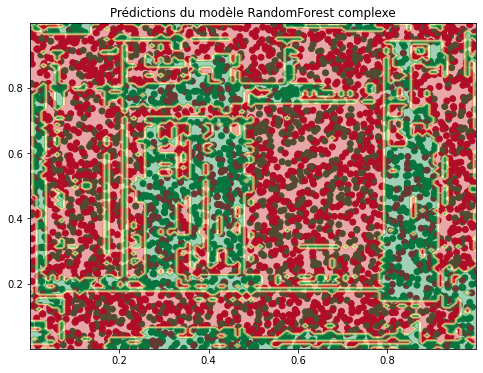

In [16]:
# On génère un dataset complexe pour que l'algorithme ait besoin d'arbres très profonds
X_complex = np.random.uniform(0, 1, size=(5000, 2))
y_complex = 1*(np.random.rand(5000) > 0.5)

clf_complex = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0).fit(X_complex, y_complex)

# On peut s'amuser à visualiser les prédictions d'un modèle RF sur ce dataset
plt.subplots(figsize=(8, 6))
plt.scatter(X_complex[:, 0], X_complex[:, 1], c=y_complex, cmap="RdYlGn")

grid_1d = np.linspace(-1.1, 1.1, 100)
xx, yy = np.meshgrid(np.linspace(X_complex[:, 0].min(), X_complex[:, 0].max(), 100), np.linspace(X_complex[:, 1].min(), X_complex[:, 1].max(), 100))
Z = clf_complex.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn")

plt.title("Prédictions du modèle RandomForest complexe")

In [32]:
times = {}
for max_depth in tqdm(range(2, 13)):
    clf_deep = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=0).fit(X_complex, y_complex)
    
    # On vérifie que tous les arbres ont la profondeur maximale,
    # c'est important pour que nos tests de performance soient valides.
    depths = [tree.get_depth() for tree in clf_deep.estimators_]
    assert all(d == max_depth for d in depths)
    
    models = get_all_backends(RandomForestGEMM, clf_deep, include_sklearn=True, include_hummingbird=True)
    
    # Pour éviter que les tests prennent trop longtemps, on retire les modèles les plus lents au bout d'un moment
    if max_depth >= 6:
        models.pop("numpy")
    if max_depth >= 8:
        models.pop("torch_cpu")
    
    times[max_depth] = time_all_backends(models, X_complex, number=10, repeat=1, return_std=False)

Text(0, 0.5, 'Time')

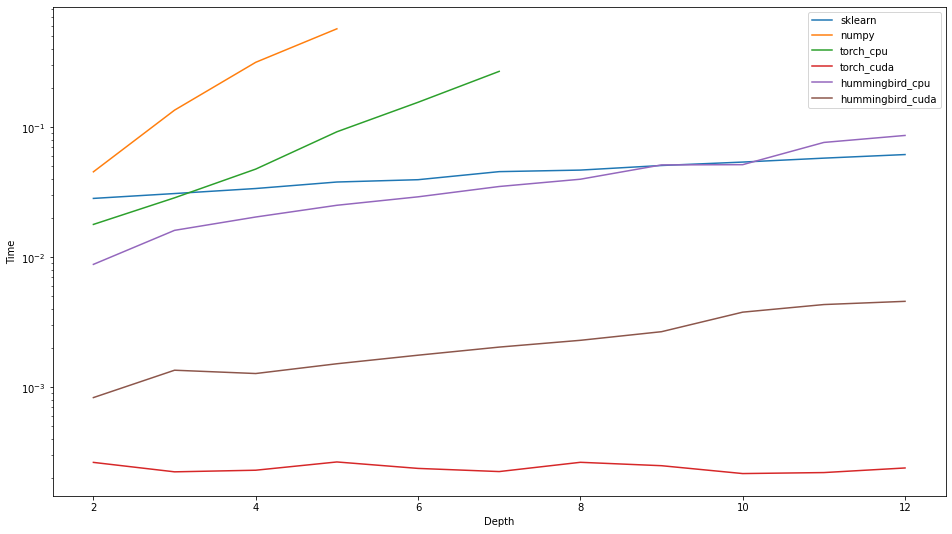

In [33]:
df = pd.DataFrame(times).T
df.plot(figsize=(16, 9), logy=True)
plt.xlabel("Depth")
plt.ylabel("Time")

In [34]:
df * 1000 # Millisecondes

,sklearn,numpy,torch_cpu,torch_cuda,hummingbird_cpu,hummingbird_cuda
2,28.273533,45.262701,17.844057,0.264761,8.799670,0.833273
3,30.815935,134.799034,28.577014,0.224015,16.069105,1.352505
4,33.685962,314.303691,47.502562,0.230502,20.346596,1.275613
5,37.789514,568.575896,91.920178,0.266775,25.041357,1.516423
6,39.371376,NaN,154.921020,0.237996,29.077942,1.764256
7,45.408534,NaN,267.765719,0.225076,34.907572,2.036292
8,46.673155,NaN,NaN,0.265149,39.703771,2.295918
9,50.622008,NaN,NaN,0.249667,51.142366,2.674329
10,53.777713,NaN,NaN,0.217261,51.364206,3.778735
11,57.656983,NaN,NaN,0.221110,76.129590,4.322532


Les modèles sur CPU se comportent comme on s'y attendait : les modèles `numpy` et `torch_cpu` voient leur temps d'exécution augmenter exponentiellement avec la profondeur des arbres à cause des $2^d-1$ tests calculés pour chaque arbre et chaque échantillon. Sur CPU, l'implémentation plus directe de `sklearn` devient donc plus rapide que la nôtre dès une profondeur de 4.

L'exception est l'implémentation CPU proposée par Hummingbird, qui résiste partiellement à la complexité exponentielle en changeant automatiquement d'algorithme pour l'inférence lorsque la profondeur dépasse un certain seuil.

Sur GPU, on assiste à un effet surprenant : le temps de calcul n'augmente presque pas avec la profondeur de l'arbre. La raison en est que le nombre d'opérations macroscopiques (multiplications de matrices) n'a pas changé : seule la taille des matrices a augmenté. Les GPUs sont particulièrement rapides sur des multiplications de très grandes matrices, et l'effet observé ici illustre bien ce principe.

Nous avons également été surpris de voir que notre implémentation surpassait Hummingbird dans le cadre de ces tests, arrivant jusqu'à un temps 19 fois inférieur (pour une profondeur de 12) ! Bien entendu, il existe probablement des combinaisons de paramètres pour lesquelles Hummingbird surpasse notre implémentation.

Cependant, à partir d'un certain seuil de profondeur qui diffère selon le hardware (8 sur une GTX 1660S, 16 sur une GTX 1070), le temps de calcul de l'implémentation `torch_cuda` augmente subitement de plusieurs ordres de grandeur. Notre interprétation est que cela est dû à une limite sur la taille des blocs manipulables par CUDA, qui force les matrices à être séparées en plusieurs sous-matrices pour les calculs et augmente considérablement le temps.

## Conclusion
Nous avons implémenté un algorithme d'optimisation des calculs d'inférence du modèle RandomForest, avec trois backends différents (`numpy`, `pytorch` en CPU et en GPU), et sous deux implémentations (naïve et optimisée). Nous avons testé les temps d'exécution des différentes méthodes sous différentes configurations et comparé à l'implémentation directe de `sklearn` et à une solution industrielle comparable (`hummingbird`). Notre implémentation utilisant `pytorch` sur GPU arrive dans certains cas à dépasser Hummingbird, ce qui montre qu'elle est de bonne qualité.

Cependant, les conclusions que nous tirons sont très dépendantes des jeux de données utilisés, des hyperparamètres imposés au modèle ainsi que du hardware que nous utilisons. Un benchmark complet devrait s'appuyer sur des variantes de ces trois facteurs, et celui-ci ne peut avoir que valeur indicative.